# OpenBSD metrics

by [Sergey Bronnikov](https://bronevichok.ru/), BSD license
![OpenBSD logo](https://www.openbsd.org/art/puffy/puf100X86.gif)

## Code


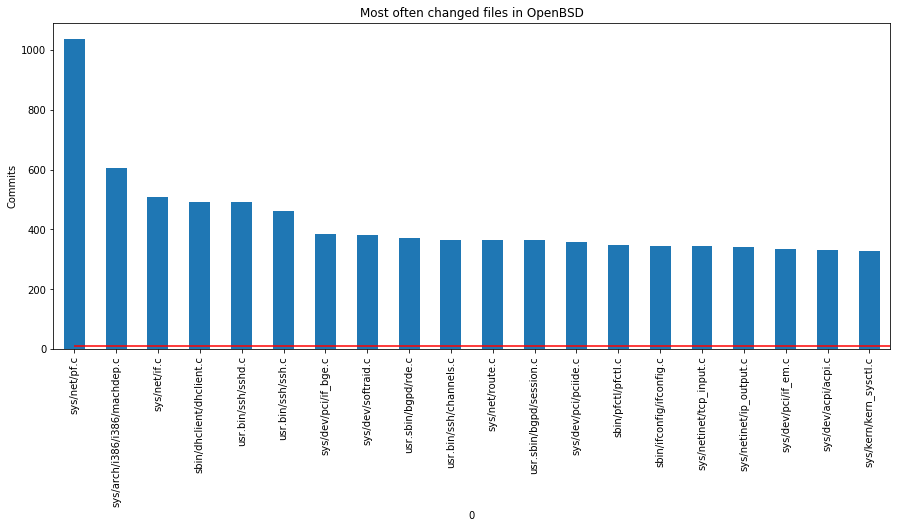

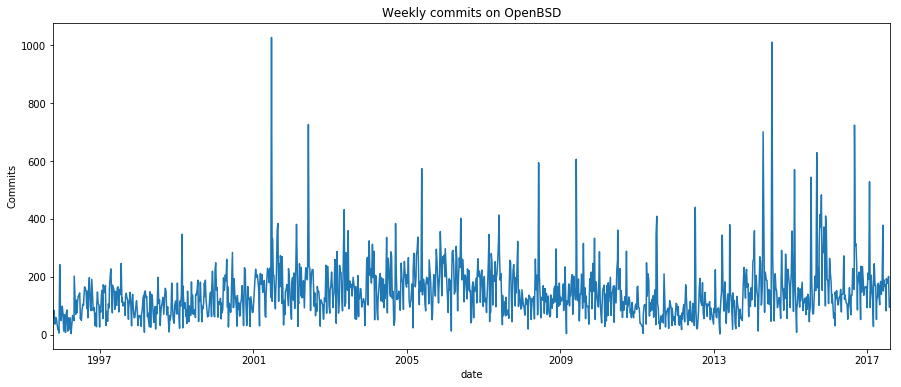

In [41]:
import pandas as pd
import json
import itertools
import collections
import numpy
import re
import datetime
import arrow
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
plt.show(block=True)

Checkout [openbsd-src](https://github.com/openbsd/src) respository and install Python package called [git2json](https://github.com/tarmstrong/git2json) for parsing git logs.

In [33]:
#!git2json --git-dir=/home/sergeyb/source/openbsd-src/.git > openbsd-src-log.json

We can parse the resulting JSON file and take a peek at the data structure.

In [42]:
log = json.load(open('openbsd-src-log.json'))
print log[0]

{u'committer': {u'date': 1502432213, u'timezone': u'+0000', u'name': u'jsg', u'email': u'jsg@openbsd.org'}, u'author': {u'date': 1502432213, u'timezone': u'+0000', u'name': u'jsg', u'email': u'jsg@openbsd.org'}, u'tree': u'270fd7887a9790f829a97123a41c61d7b0b5895a', u'parents': [u'928e0665bda66001e40e92b2ec7fc45ec2d350f5'], u'commit': u'7ad305969440696d266904cc2f6f66e4bbc5612a', u'message': u'sync', u'changes': [[1, 1, u'distrib/sets/lists/base/mi']]}


### Common numbers

In [43]:
def commit_ts_to_date(commit_num):
    commit_ts = log[commit_num]["committer"]["date"]
    commit_date = datetime.datetime.fromtimestamp(int(commit_ts)).strftime('%Y-%m-%d')
    return commit_date

print "First commit on: ", commit_ts_to_date(-1)
print "Last commit on: ", commit_ts_to_date(1)

print "Number of commits = ", len(log)

committers = [c['committer']['name'] for c in log]
print "Number of committers = ", len(set(committers))

authors = [a['author']['name'] for a in log]
print "Number of authors = ", len(set(authors))

changes = [commit for changeset in log for commit in changeset['changes']]
files = [file[2] for file in changes]
print "Number of files = ", len(set(files))

First commit on:  1995-10-18
Last commit on:  2017-08-11
Number of commits =  184518
Number of committers =  360
Number of authors =  360
Number of files =  133499


### Most often changed source files

This is a simplified version of "code churn" which is [reasonably](https://research.microsoft.com/apps/pubs/default.aspx?id=69126) [effective](http://google-engtools.blogspot.ca/2011/12/bug-prediction-at-google.html) for predicting bugs. (More complicated models include lines modified or [take semantic differences into account](http://dl.acm.org/citation.cfm?id=1985456)). So we'll just take the number of commits for each `.c` file.

In [44]:
file_changes = lambda: itertools.chain.from_iterable(
    [change[2] for change in commit['changes'] if re.match(r'^.*\.c$', change[2])]
    for commit in log
)

In [46]:
plt.rcParams["figure.figsize"] = (15,6)
fchanges = file_changes()
fchange_count = collections.Counter(fchanges)
a = numpy.average(fchange_count.values())
most_common = fchange_count.most_common(20)
df = pd.DataFrame(most_common)
df.head()
df.index = df[0]
df = df[[1]]
df.head()
p = df.plot(kind='bar', legend=False)
p.set_title('Most often changed files in OpenBSD')
p.set_ylabel('Commits')
plt.hlines(a, 0, len(df), colors='r')

### Commits per week

Next, I'll make a simple plot showing weekly commit counts over time, similar to the plots GitHub would show you. I
We'll create a data frame from a list in the format `[(date_rounded_down_to_week, commit_id)]` and then `groupby()` the date.

In [75]:
def weekly_date_resolution(ts):
    ar = arrow.Arrow.utcfromtimestamp(ts)
    day_of_month = ar.timetuple().tm_mday
    week = int(day_of_month) / 7
    new_day = (week*7)+1
    assert new_day > 0
    assert new_day < 30
    try:
        day_adjusted = ar.replace(day=new_day)
    except ValueError:
        new_day = day_of_month
        day_adjusted = ar.replace(day=new_day)
    return day_adjusted.date()

commit_times = lambda: (
    (weekly_date_resolution(commit['committer']['date']), commit['commit'])
    for commit in log
)

dfct = pd.DataFrame(commit_times(), columns=['date', 'id'])
dfct = dfct.groupby('date').aggregate(len)
dfct.tail()

,id
date,
2017-07-15,179
2017-07-22,201
2017-07-29,96
2017-08-01,94
2017-08-08,124


A few more lines gives us a basic plot.

In [48]:
p = dfct.plot(legend=False)
p.set_title('Weekly commits on OpenBSD')
p.set_ylabel('Commits')

### Commits per week in regress/

In [76]:
def is_regress(changes_list):
    for c in changes_list:
        if 'regress' in c[2]:
            return True
    return False

commit_times = [(weekly_date_resolution(commit['committer']['date']), commit['commit'])
                for commit in log if is_regress(commit['changes'])
]

dfrct = pd.DataFrame(commit_times, columns=['date', 'id'])
dfrct = dfct.groupby('date').aggregate(len)
dfrct.tail()

,id
date,
2017-07-15,1
2017-07-22,1
2017-07-29,1
2017-08-01,1
2017-08-08,1


In [77]:
r = dfrct.plot(legend=False)
r.set_title('Weekly commits in regress')
r.set_ylabel('Commits')

### Number of active developers per month (WIP)

In [89]:
commit_names = lambda: (
    (weekly_date_resolution(commit['committer']['date']), commit['committer']['name'])
    for commit in log
)

dfcn = pd.DataFrame(commit_names(), columns=['date', 'name'])
dfcn = dfcn.groupby('date')
dfcn.head()

,date,name
0,2017-08-08,jsg
1,2017-08-08,jsing
2,2017-08-08,doug
3,2017-08-08,djm
4,2017-08-08,djm
124,2017-08-01,krw
125,2017-08-01,robert
126,2017-08-01,kettenis
127,2017-08-01,kettenis
128,2017-08-01,rob


### Developers activity by time (WIP)

In [49]:
commit_times = lambda: (
    (commit['committer']['name'], weekly_date_resolution(commit['committer']['date']))
    for commit in log
)

dfct = pd.DataFrame(commit_times(), columns=['name', 'date'])

dfct.date = pd.to_datetime(dfct.date)
dg = dfct.groupby(pd.Grouper(key='date', freq='Y')).sum() # groupby each 1 month
dg.index = dg.index.strftime('%B')
dg.head()

#dfct.groupby([dfct['date'].dt.year, dfct['date'].dt.month]).agg({'count'})

ValueError: Invalid frequency: Y

The most active developers

In [ ]:
devs = lambda: (
    (c['committer']['name'], c['changes'])
    for c in log
)

dfad = pd.DataFrame(devs(), columns=['name', 'num'])
dfad = dfad.groupby('name').aggregate(len)
dfad.head()

In [ ]:
pad = dfad.plot(legend=False)
pad.set_title('The most active developers')
pad.set_ylabel('Commits')

## Bugs

Perhaps you know that OpenBSD project doesn't have official bug tracker. Therefore mailing list [bugs@openbsd.org](https://www.openbsd.org/report.html)
is the only single place to find information about OpenBSD defects. Let's analyze it to gather interesting metrics.
First of all we should download mail archive of openbsd-bugs from [Majordomo](https://lists.openbsd.org/cgi-bin/mj_wwwusr?user=&passw=&func=lists-long) and [mbox2json](https://gist.github.com/ligurio/06a9fd236c70fe9dcf0f769823a0aeee) script.

In [ ]:
mbox = json.load(open('openbsd-bugs.mbox.json'))
print mbox[0]

In [ ]:
reports = [m for m in mbox if not re.search("Re:", m['subject'])] # aka first messages in threads
reporters = [m['from'] for m in reports]
print "Number of bug reporters: ", len(set(reporters))
print "Number of bugs: ", len(reports)

### Bugreports per week

In [51]:
def normalize_date(date_string):
    # Example: Sat, 31 May 2003 14:40:40 -0400
    from dateutil import parser
    try:
        date = parser.parse(date_string).strftime("%Y-%m-%d")
    except ValueError:
        date = "0000-00-00"  # FIXME: improve date parsing
    return date
    
report_times = lambda: (
    (normalize_date(message['date']), message['subject'])
    for message in reports
)

dfbg = pd.DataFrame(report_times(), columns=['date', 'id'])
dfbg = dfbg.groupby('date').aggregate(len)
dfbg.head()

,id
date,
0000-00-00,2
2003-05-01,5
2003-05-02,7
2003-05-03,4
2003-05-04,2


In [52]:
b = dfbg.plot(legend=False)
b.set_title('Weekly bugreports on OpenBSD')
b.set_ylabel('Bugs')

### The most active bugreporters

In [53]:
def extract_domain(from_email):
    return from_email.split("@")[1].split(">")[0]

domains = [(extract_domain(message['from']), message['subject']) for message in reports]

dfdomain = pd.DataFrame(m, columns=['domain', 'id'])
dfdomain = dfdomain.groupby('domain').aggregate(len)
dfdomain.head()

,id
domain,
acm.org,1
agliodbs.com,3
anklebiter.net,1
aon.at,1
aurigin.com,2


In [54]:
d = dfdomain.plot(legend=False)
d.set_title('Weekly bugreports on OpenBSD')
d.set_ylabel('Bugs')

### Time to response (WIP)

In [56]:
def extract_domain(from_email):
    return from_email.split("@")[1].split(">")[0]

domains = lambda: (
    (extract_domain(message['from']), message['subject'])
    for message in reports
)

dfdomain = pd.DataFrame(domains(), columns=['domain', 'id'])
dfdomain = dfdomain.groupby('domain').aggregate(len)
dfdomain.head()

,id
domain,
acm.org,1
agliodbs.com,3
anklebiter.net,1
aon.at,1
aurigin.com,2


## Errata

- https://www.openbsd.org/errata61.html
- see https://github.com/ligurio/openbsd-tests/wiki/OpenBSD-errata-statistics